In [1]:
import google.generativeai as genai
import os
from dotenv import load_dotenv

# Carrega as variáveis do arquivo .env
load_dotenv()

# Obtém a chave da API do arquivo .env
gemini_api_key = os.getenv("GEMINI_API_KEY")
genai.configure(api_key=gemini_api_key)

c:\Users\gabri\projects\TPS\TP2_EngPrompt\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
import yaml
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Carregar o arquivo
with open('../data/roteiro_json.yaml', 'r') as arquivo:
    roteiro = yaml.safe_load(arquivo)

# Inicializar o modelo
model = genai.GenerativeModel("gemini-1.5-flash")

# Armazenar os pontos turísticos
tourist_data = []

# Função converter em JSON
def extract_json_from_response(response_text):
    cleaned_text = response_text.strip().strip("```json").strip("```")
    cleaned_text = cleaned_text.replace("\n", "").replace("\r", "")
    cleaned_text = cleaned_text.replace(",}", "}")

    return json.loads(cleaned_text)

# Executando os prompts
for cidade, prompt in roteiro['roteiro'].items():
    resposta = model.generate_content(prompt)
    print(resposta)  
    
    if hasattr(resposta, 'candidates'):
        resposta_text = resposta.candidates[0].content.parts[0].text
    
        # Converter em um dicionário
        try:
            resposta_json = extract_json_from_response(resposta_text)
   
            for spot in resposta_json['tourist_spots']:
                tourist_data.append({
                    "City": resposta_json["city"],
                    "Tourist Spot": spot["name"],
                    "Description": spot["description"],
                    "Visitors per Year": spot["visitors_per_year"]
                })
        except json.JSONDecodeError as e:
            print(f"Erro ao processar a resposta JSON para {cidade}: {e}")

response:
GenerateContentResponse(
    done=True,
    iterator=None,
    result=protos.GenerateContentResponse({
      "candidates": [
        {
          "content": {
            "parts": [
              {
                "text": "```json\n{\"city\": \"Atenas\", \"tourist_spots\": [\n    {\"name\": \"Acr\u00f3pole\", \"description\": \"A Acr\u00f3pole \u00e9 um antigo complexo de monumentos localizado em Atenas, Gr\u00e9cia. Foi constru\u00eddo no s\u00e9culo V a.C. e \u00e9 considerado um dos monumentos mais importantes da hist\u00f3ria da arquitetura ocidental. O local abriga v\u00e1rios edif\u00edcios importantes, incluindo o Parthenon, um templo dedicado \u00e0 deusa Atena.\", \"visitors_per_year\": \"7 milh\u00f5es\"},\n    {\"name\": \"Museu da Acr\u00f3pole\", \"description\": \"O Museu da Acr\u00f3pole \u00e9 um museu dedicado \u00e0 hist\u00f3ria da Acr\u00f3pole e abriga muitos artefatos importantes, incluindo esculturas, cer\u00e2mica e outras descobertas arqueol\u00f3gicas

In [21]:
# Converter os dados para um DataFrame
df = pd.DataFrame(tourist_data)
df

,City,Tourist Spot,Description,Visitors per Year
0,Atenas,Acrópole,A Acrópole é um antigo complexo de monumentos ...,7 milhões
1,Atenas,Museu da Acrópole,O Museu da Acrópole é um museu dedicado à hist...,1 milhão
2,Atenas,Ágora Antiga,"A Ágora Antiga era o centro comercial, polític...",500 mil
3,Roma,Coliseu,"Um anfiteatro romano antigo, construído no séc...","7,4 milhões"
4,Roma,Fórum Romano e Palatino,"Os restos de um antigo fórum romano, centro po...","3,2 milhões"
5,Roma,Museus do Vaticano,Um complexo de museus que abriga algumas das o...,"6,4 milhões"


In [22]:
# Conversão do número de visitantes
def convert_visitors(visitors_str):
    visitors_str = visitors_str.replace(',', '.')
    if 'milh' in visitors_str:
        return float(visitors_str.replace(' milhões', '').replace(' milhão', '')) * 1e6
    elif 'mil' in visitors_str:
        return float(visitors_str.replace(' mil', '')) * 1e3
    return float(visitors_str)

df['Visitors per Year'] = df['Visitors per Year'].apply(convert_visitors)


df['Visitors per Year'] = df['Visitors per Year'].apply(lambda x: "{:,.0f}".format(x))


print(df)

     City             Tourist Spot  \
0  Atenas                 Acrópole   
1  Atenas        Museu da Acrópole   
2  Atenas             Ágora Antiga   
3    Roma                  Coliseu   
4    Roma  Fórum Romano e Palatino   
5    Roma       Museus do Vaticano   

                                         Description Visitors per Year  
0  A Acrópole é um antigo complexo de monumentos ...         7,000,000  
1  O Museu da Acrópole é um museu dedicado à hist...         1,000,000  
2  A Ágora Antiga era o centro comercial, polític...           500,000  
3  Um anfiteatro romano antigo, construído no séc...         7,400,000  
4  Os restos de um antigo fórum romano, centro po...         3,200,000  
5  Um complexo de museus que abriga algumas das o...         6,400,000  


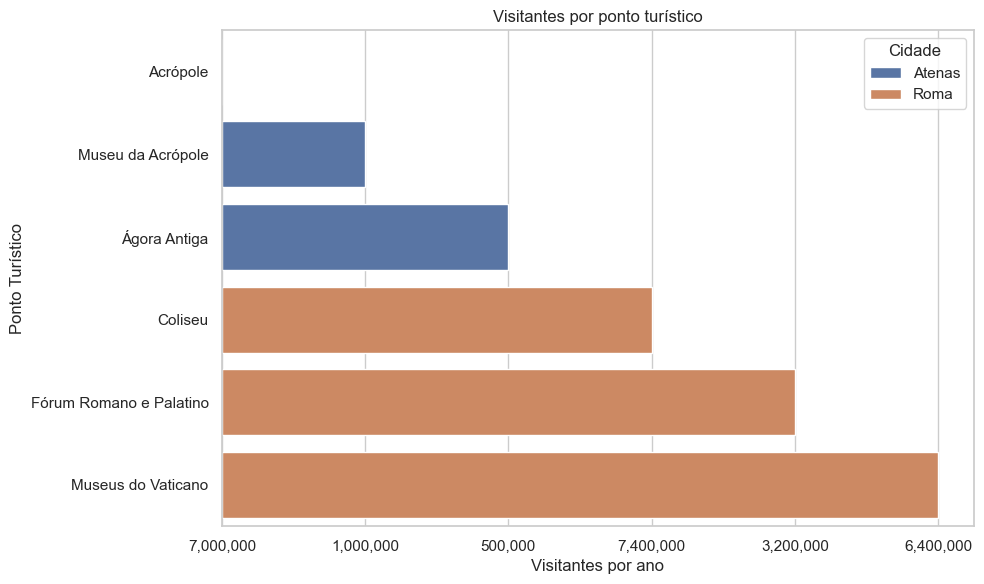

In [28]:
# Plot de barras
plt.figure(figsize=(10, 6)) 
sns.barplot(x='Visitors per Year', y='Tourist Spot', hue='City', data=df, orient='h', dodge=False)

# Labels e title
plt.xlabel('Visitantes por ano')
plt.ylabel('Ponto Turístico')
plt.title('Visitantes por ponto turístico')
plt.legend(title='Cidade') 
plt.tight_layout()
plt.show()